In [1]:
! pip install verde harmonica pandas matplotlib

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import harmonica as hm
import verde as vd
import pandas as pd
import warnings

In [3]:
warnings.filterwarnings('ignore')

In [4]:
region = [0, 100e3, 0, 90e3] 
spacing = (500,5000) # Espaçamento entre as linhas de voo
coordinates = vd.grid_coordinates(region=region, spacing=spacing, extra_coords=500) # Coordenadas do levantamento 


Com spacing=5000, R_2 verdadeiro = 0.9969935689798417

média sem blocos = mean: 0.7517748627264079

média com blocos = mean: 0.6484019128353826

Com spacing=10000, R_2 verdadeiro = -0.04194173260685585

média sem blocos = mean: -0.08553868650921963

média com blocos = -0.04198072658162777

Com spacing=1000, R_2 verdadeiro = 0.9999957968369876

média sem blocos = 0.9999633167325591 

média com blocos = 0.9998211670181172

In [5]:
def plot_region(ax, region):
    "Plot the region as a solid line."
    west, east, south, north = region
    ax.add_patch(
        plt.Rectangle((west, south), east, north, fill=None, label="Region Bounds")
    )

def plot_grid(ax, coordinates, linestyles="dotted", region=None, pad=50, **kwargs):
    "Plot the grid coordinates as dots and lines."
    data_region = vd.get_region(coordinates)
    ax.vlines(
        coordinates[0][0],
        ymin=data_region[2],
        ymax=data_region[3],
        linestyles=linestyles,
        zorder=0,
    )
    ax.hlines(
        coordinates[1][:, 1],
        xmin=data_region[0],
        xmax=data_region[1],
        linestyles=linestyles,
        zorder=0,
    )
    ax.scatter(*coordinates, **kwargs)
    if pad:
        padded = vd.pad_region(region, pad=pad)
        plt.xlim(padded[:2])
        plt.ylim(padded[2:])

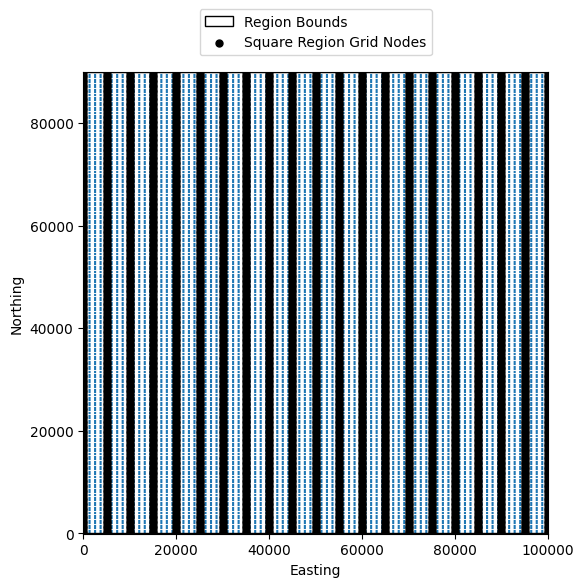

In [6]:
easting, northing = coordinates[0], coordinates[1]
plt.figure(figsize=(6, 6))
ax = plt.subplot(111)
plot_region(ax=ax, region=region)
plot_grid(
    coordinates=[easting,northing],
    ax=ax,
    region=region,
    label="Square Region Grid Nodes",
    marker=".",
    color="black",
    s=100,
)

plt.xlabel("Easting")
plt.ylabel("Northing")
plt.legend(loc="upper center", bbox_to_anchor=(0.5, 1.15))
plt.show()

In [7]:


prismas = [
    [10e3, 15e3, 20e3, 35e3, -1e3,  0],
    [60e3, 80e3, 50e3, 70e3, -2e3,  -0.5e3],
]
densidades = [500, -300]
gz = hm.prism_gravity(coordinates, prismas, densidades, field="g_z") #gz gerado pelos prismas
# criando a malha regular pra plotar o R_2 verdadeiro
grid_coordinates = vd.grid_coordinates(region=region, spacing=2000, extra_coords=500) # coordenadas da malha regular
gz_grid = hm.prism_gravity(grid_coordinates, prismas, densidades, field="g_z") #grid gz 
grid_true = vd.make_xarray_grid(grid_coordinates, gz_grid, data_names="g_z", extra_coords_names="upward")#grid regular

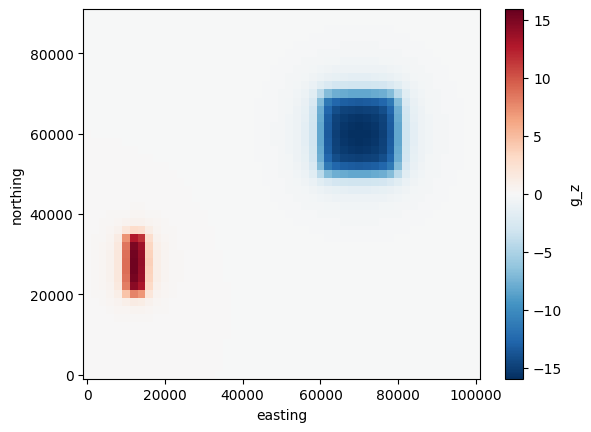

In [8]:
grid_true.g_z.plot()

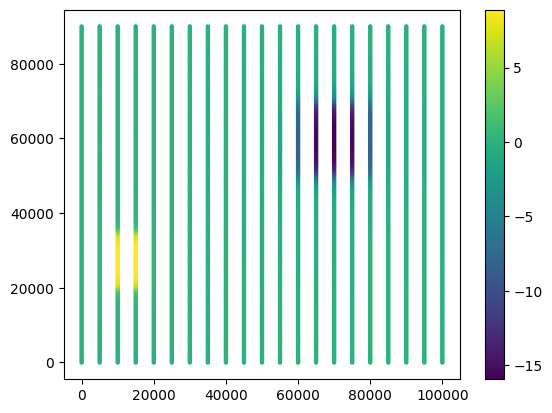

In [9]:
plt.scatter(coordinates[0],coordinates[1],s=5,c=gz)
plt.colorbar() # resultado do levantamento

# Fontes Equivalentes

In [10]:
fontes = hm.EquivalentSourcesGB(damping=1,depth=2000)

fontes.fit([coordinates[0],coordinates[1],coordinates[2]],data=gz) 

EquivalentSourcesGB(damping=1, depth=2000)

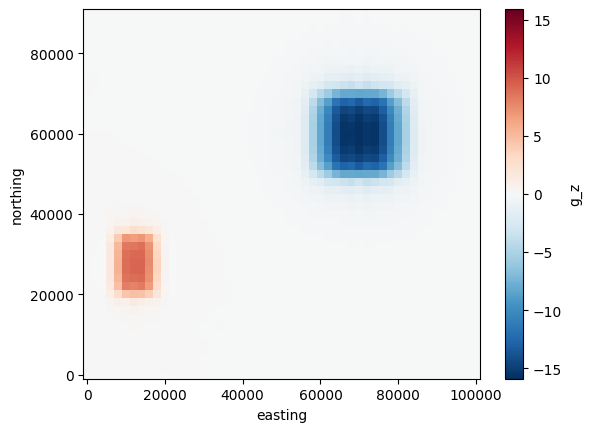

In [11]:
gz_grid_eq = fontes.grid(grid_coordinates,data_names="g_z")
gz_grid_eq.g_z.plot() # resultado utilizando fontes equivalentes (interpolação dos dados entre as linhas de voo)

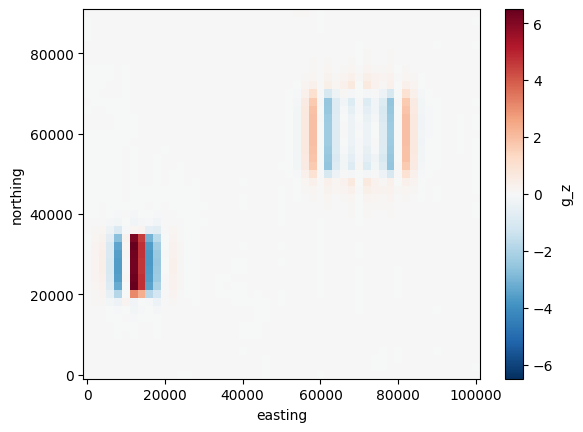

In [12]:
# Plotando a diferença entre grid_true (levantamento na malha regular) e gz_grid_eq (fontes equivalentes)

residuo = grid_true - gz_grid_eq
residuo.g_z.plot()

# R_2 verdadeiro

In [13]:
g_z_medio = np.sum(grid_true.g_z.values)/np.size(grid_true.g_z)
residuo_quadrado = np.sum(residuo.g_z.values**2)
R_2_true = 1 - (residuo_quadrado/np.sum([(gz - g_z_medio)**2 for gz in grid_true.g_z.values]))

R_2_true

0.959831903760306

# Using cross-validation to evaluate how well
# these equivalent sources can accurately predict the values of the field

In [14]:

R_2_kfold = (
    vd.cross_val_score(
        fontes,
        coordinates,
        gz,
    )
)


In [15]:
print(f"min: {np.min(R_2_kfold)}")
print(f"max: {np.max(R_2_kfold)}")
print(f"mean: {np.mean(R_2_kfold)}")

min: 0.999852451243023
max: 0.9999215224748064
mean: 0.9998943160247336


# Blocking

A média dos R_2 (calculados através da validação cruzada por blocos) equivale ao R_2 verdadeiro com um tamanho de bloco de aproxidamente 5000km, que é o espaçamento entre as linhas de voo.

O valor máximo dos R_2 equivale ao R_2 verdadeiro com um tamanho de bloco de aproximadamente 8000km (um pouco maior que este valor).



In [16]:


R_2_block = (
    vd.cross_val_score(
        fontes,
        coordinates,
        gz,
        cv=vd.BlockKFold(spacing=5000, n_splits=5, shuffle=True, random_state=123),
    )
)


In [17]:
print(f"min: {np.min(R_2_block)}")
print(f"max: {np.max(R_2_block)}")
print(f"mean: {np.mean(R_2_block)}")

min: 0.9035396675612886
max: 0.9786407498785515
mean: 0.9524938235582715


# Variando o número de splits
Estou pegando a média dos erros para plotar

In [18]:
#Data are first grouped into rectangular blocks of size given by the spacing argument.
# The blocks are then split into testing and training sets iteratively along k folds of the data
#(k is given by n_splits).
R_2_splits_media = [] # Variando o numero de splits
n = np.arange(5,21)
for n_splits in n:
    R_2_splits_media.append(np.mean(
        vd.cross_val_score(
            fontes,
            coordinates,
            gz,
            cv=vd.BlockKFold(spacing=5000, n_splits=n_splits, shuffle=True, random_state=123),
        )
    ))



In [19]:
# Quero achar o numero mais proximo de R_2_true dentro de R_2_block
# E encontrar o n associado a este valor 

def acha_indice(R_2_true,lista):
    "Encontra o valor mais próximo de R_2_true dentro da lista e retorna sua posição dentro dela."
    valores = []
    for element in lista:
        valores.append(np.abs(element-R_2_true))
    indice = valores.index(np.min(valores))
    return indice

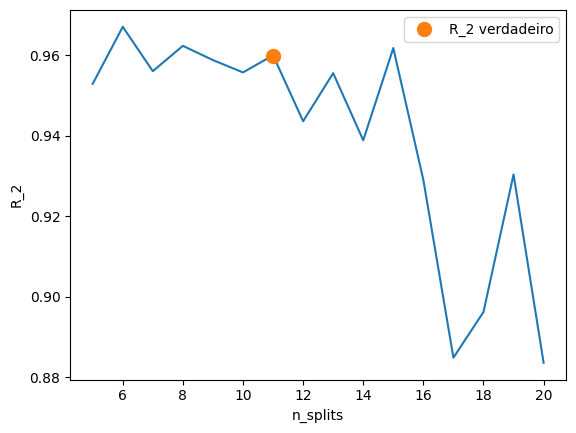

In [20]:
indice = acha_indice(R_2_true,R_2_splits_media)
plt.plot(n,R_2_splits_media)
plt.xlabel("n_splits")
plt.ylabel("R_2")
plt.plot(n[indice],R_2_true,"o",markersize=10,label=f"R_2 verdadeiro")
plt.legend()

# Variando tamanho do bloco
Estou pegando a média dos erros para plotar

In [21]:
R_2_block_media = []
block = np.linspace(1000,10000,10)
for spacing in block:
    R_2_block_media.append(np.mean(
        vd.cross_val_score(
            fontes,
            coordinates,
            gz,
            cv=vd.BlockKFold(spacing=spacing, n_splits=5, shuffle=True, random_state=123),
        )
    ))



Text(0, 0.5, 'R_2')

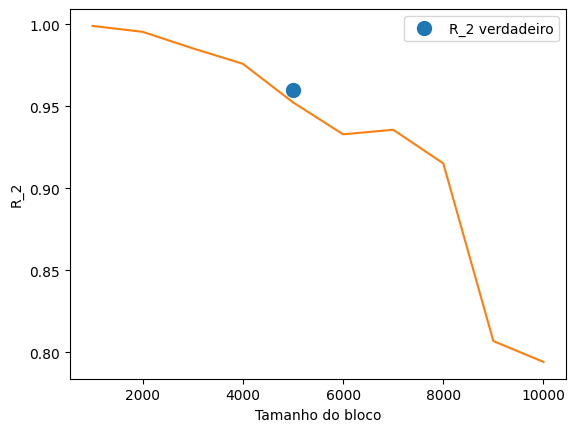

In [22]:
indice = acha_indice(R_2_true,R_2_block_media)
plt.plot(block[indice],R_2_true,"o",markersize=10,label=f"R_2 verdadeiro")
plt.plot(block,R_2_block_media)
plt.legend()
plt.xlabel("Tamanho do bloco")
plt.ylabel("R_2")


# Variando n_splits

Pegando o valor máximo dos erros para plotar

In [23]:
R_2_splits_max = [] # Variando splits e pegando o minimo dos valores
n = np.arange(2,11)
for n_splits in n:
    R_2_splits_max.append(np.max(
        vd.cross_val_score(
            fontes,
            coordinates,
            gz,
            cv=vd.BlockKFold(spacing=5000, n_splits=n_splits, shuffle=True, random_state=123),
        )
    ))


Text(0, 0.5, 'R_2')

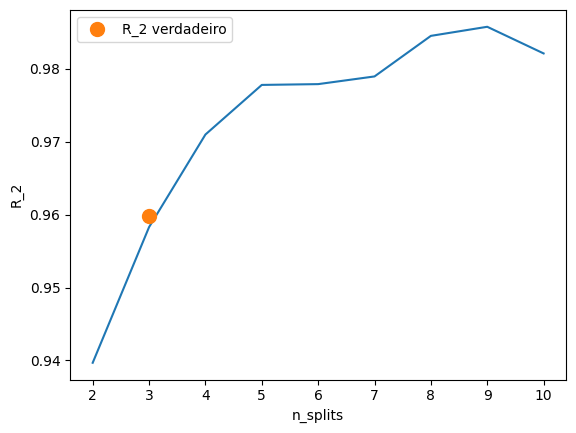

In [24]:
plt.plot(n,R_2_splits_max)
indice = acha_indice(R_2_true,R_2_splits_max)
plt.plot(n[indice],R_2_true,"o",markersize=10,label=f"R_2 verdadeiro")
plt.legend()
plt.xlabel("n_splits")
plt.ylabel("R_2")

# Variando tamanho do bloco
Pegando o valor máximo para plotar

In [25]:
R_2_block_max = []
block = np.arange(1000,10950,950)
nsplits=5
for spacing in block:
    R_2_block_max.append(np.max(
        vd.cross_val_score(
            fontes,
            coordinates,
            gz,
            cv=vd.BlockKFold(spacing=spacing, n_splits=nsplits, shuffle=True, random_state=123),
        )
    ))



Text(0, 0.5, 'R_2')

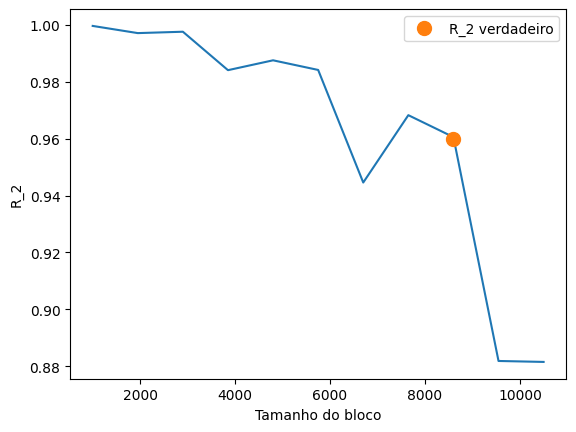

In [26]:
plt.plot(block,R_2_block_max)
indice = acha_indice(R_2_true,R_2_block_max)
plt.plot(block[indice],R_2_true,"o",markersize=10,label=f"R_2 verdadeiro")
plt.legend()
plt.xlabel("Tamanho do bloco")
plt.ylabel("R_2")

In [27]:
#pcolormesh
